노드에 있는 소스코드가 이해가 전혀 되지 않아서 구글링을 통해 이해한 뒤 작성하였습니다.

# PROJECT 12. CIFAR-10 이미지 생성하기
GAN 모델 구조를 이용해서 CIFAR-10 이미지를 생성하는 모델을 만들어보도록 하겠습니다.

## 1. 데이터 살펴보기
CIFAR10 데이터 셋은 32x32 크기의 RGB 이미지 5만개로 이루어져 있고 10개의 클래스를 가집니다. (각 클래스 별로 5,000개의 이미지가 있습니다.)

### 1.1 데이터 가져오기
tf.keras 안의 datasets 에서 CIFAR-10 데이터셋을 가져옵니다.

In [16]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

cifar10 = tf.keras.datasets.cifar10    # CIFAR-10 데이터 셋

(x_train, y_train), (_, _) = cifar10.load_data()    # 각 이미지가 어떤 카테고리인지 나타내는 라벨이 필요 없음 

print('x_train shape :', x_train.shape)
print('y_train shape :', y_train.shape)

x_train shape : (50000, 32, 32, 3)
y_train shape : (50000, 1)


CIFAR-10 데이터 셋은 총 50,000개로 구성되어 있습니다.  
CIFAR-10의 각 데이터 픽셀은 32(w) x 32(h) 이고, 컬러 이미지(3채널) 입니다.

### 1.2 데이터 시각화하기
CIFAR10 데이터를 라벨 별로 시각화해서 출력해보도록 하겠습니다.

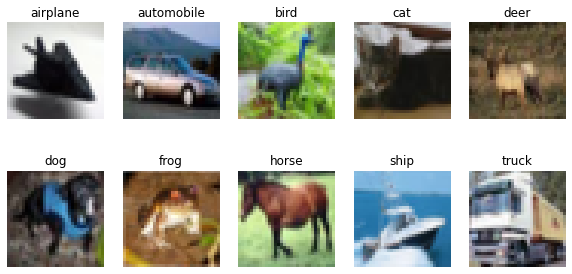

In [17]:
from collections import OrderedDict
plt.figure(figsize=(10, 5))

x_dict = OrderedDict()
# label 0 : airplane
x_dict['airplane'] = x_train[y_train.flatten() == 0]
plt.subplot(2, 5, 1)
plt.imshow(x_dict['airplane'][0])
plt.title("airplane")
plt.axis('off')

# label 1 : automobile
x_dict['automobile'] = x_train[y_train.flatten() == 1]
plt.subplot(2, 5, 2)
plt.imshow(x_dict['automobile'][0])
plt.title("automobile")
plt.axis('off')

# label 2 : bird
x_dict['bird'] = x_train[y_train.flatten() == 2]
plt.subplot(2, 5, 3)
plt.imshow(x_dict['bird'][0])
plt.title("bird")
plt.axis('off')

# label 3 : cat
x_dict['cat'] = x_train[y_train.flatten() == 3]
plt.subplot(2, 5, 4)
plt.imshow(x_dict['cat'][0])
plt.title("cat")
plt.axis('off')

# label 4 : deer
x_dict['deer'] = x_train[y_train.flatten() == 4]
plt.subplot(2, 5, 5)
plt.imshow(x_dict['deer'][0])
plt.title("deer")
plt.axis('off')

# label 5 : dog
x_dict['dog'] = x_train[y_train.flatten() == 5]
plt.subplot(2, 5, 6)
plt.imshow(x_dict['dog'][0])
plt.title("dog")
plt.axis('off')

# label 6 : frog
x_dict['frog'] = x_train[y_train.flatten() == 6]
plt.subplot(2, 5, 7)
plt.imshow(x_dict['frog'][0])
plt.title("frog")
plt.axis('off')

# label 7 : horse
x_dict['horse'] = x_train[y_train.flatten() == 7]
plt.subplot(2, 5, 8)
plt.imshow(x_dict['horse'][0])
plt.title("horse")
plt.axis('off')

# label 8 : ship
x_dict['ship'] = x_train[y_train.flatten() == 8]
plt.subplot(2, 5, 9)
plt.imshow(x_dict['ship'][0])
plt.title("ship")
plt.axis('off')

# label 9 : truck
x_dict['truck'] = x_train[y_train.flatten() == 9]
plt.subplot(2, 5, 10)
plt.imshow(x_dict['truck'][0])
plt.title("truck")
plt.axis('off')

plt.show()

### 1.3 데이터 정규화하기
학습에 사용할 이미지의 픽셀을 (-1, 1)로 정규화 시키도록 하겠습니다.

In [18]:
for key, val in x_dict.items():
    x_dict[key] = x_dict[key].reshape(
    (x_dict[key].shape[0],) + (32, 32, 3)).astype('float32') / 255.
    print(f"{key} max pixel:", x_dict[key].max())
    print(f"{key} min pixel:", x_dict[key].min())
    print()

airplane max pixel: 1.0
airplane min pixel: 0.0

automobile max pixel: 1.0
automobile min pixel: 0.0

bird max pixel: 1.0
bird min pixel: 0.0

cat max pixel: 1.0
cat min pixel: 0.0

deer max pixel: 1.0
deer min pixel: 0.0

dog max pixel: 1.0
dog min pixel: 0.0

frog max pixel: 1.0
frog min pixel: 0.0

horse max pixel: 1.0
horse min pixel: 0.0

ship max pixel: 1.0
ship min pixel: 0.0

truck max pixel: 1.0
truck min pixel: 0.0



## 2. GAN 구현하기

GAN 구조는 다음과 같습니다.  
1. generator 는 (100,) 크기의 벡터를 (32, 32, 3) 크기의 이미지로 생성합니다.  


2. discriminator 는 (32, 32, 3) 크기의 이미지가 진짜일 확률을 추청하여 이진값으  


3. generator 와 discriminator 를 연결하는 gan 을 생성합니다. : gan(x) = discriminator(generator(x))  


4. "진짜","가짜" 레이블과 함께 진짜 이미지와 가짜 이미지를 사용하여 discriminator 를 훈련합니다.  


5. gan 모델의 loss 에 대한 생성자 가중치의 그래디언트를 사용하여 generator 를 훈련합니다.   
epoch 마다 generator 에 의해 디코딩된 이미지를 discriminator 가 "진짜로" 분류하도록 만드는 방향으로 generator 의 가중치를 이동시킵니다.  
즉, discriminator 를 속이도록 생성자를 훈련합니다.


### 2.1 Generator (생성자)
먼저 (100, ) 크기를 가지는 벡터를 (32, 32, 3) 크기를 가지는 가짜 이미지로 변환하는 generator 모델을 만들어보도록 하겠습니다.  
*드롭아웃을 사용하면 잘 생성됩니다.*

In [44]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

latent_dim = 32
height = 32
width = 32
channels = 3

generator_input = keras.Input(shape=(latent_dim,))

# 입력을 16 × 16 크기의 128개 채널을 가진 특성 맵으로 변환합니다
gen_x = layers.Dense(128 * 16 * 16)(generator_input)
gen_x = layers.LeakyReLU()(gen_x)
gen_x = layers.Reshape((16, 16, 128))(gen_x)

# 합성곱 층을 추가합니다
gen_x = layers.Conv2D(256, 5, padding='same')(gen_x)
gen_x = layers.LeakyReLU()(gen_x)

# 32 × 32 크기로 업샘플링합니다
gen_x = layers.Conv2DTranspose(256, 4, strides=2, padding='same')(gen_x)
gen_x = layers.LeakyReLU()(gen_x)

# 합성곱 층을 더 추가합니다
gen_x = layers.Conv2D(256, 5, padding='same')(gen_x)
gen_x = layers.LeakyReLU()(gen_x)
gen_x = layers.Conv2D(256, 5, padding='same')(gen_x)
gen_x = layers.LeakyReLU()(gen_x)

# 32 × 32 크기의 1개 채널을 가진 특성 맵을 생성합니다
gen_x = layers.Conv2D(channels, 7, activation='tanh', padding='same')(gen_x)
generator = keras.models.Model(generator_input, gen_x)
generator.summary()

Model: "model_27"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        [(None, 32)]              0         
_________________________________________________________________
dense_12 (Dense)             (None, 32768)             1081344   
_________________________________________________________________
leaky_re_lu_54 (LeakyReLU)   (None, 32768)             0         
_________________________________________________________________
reshape_6 (Reshape)          (None, 16, 16, 128)       0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 256)       819456    
_________________________________________________________________
leaky_re_lu_55 (LeakyReLU)   (None, 16, 16, 256)       0         
_________________________________________________________________
conv2d_transpose_6 (Conv2DTr (None, 32, 32, 256)       104

### 2.2 Discriminator (판별자)
진짜 이미지 혹은 가짜 이미지를 입력으로 받고 두 개의 클래스로 분류하는 discriminator 모델을 만들어보도록 하겠습니다.

In [45]:
discriminator_input = layers.Input(shape=(height, width, channels))
dis_x = layers.Conv2D(128, 3)(discriminator_input)
dis_x = layers.LeakyReLU()(dis_x)
dis_x = layers.Conv2D(128, 4, strides=2)(dis_x)
dis_x = layers.LeakyReLU()(dis_x)
dis_x = layers.Conv2D(128, 4, strides=2)(dis_x)
dis_x = layers.LeakyReLU()(dis_x)
dis_x = layers.Conv2D(128, 4, strides=2)(dis_x)
dis_x = layers.LeakyReLU()(dis_x)
dis_x = layers.Flatten()(dis_x)

# 드롭아웃 층을 넣는 것이 아주 중요합니다!
dis_x = layers.Dropout(0.4)(dis_x)

# 분류 층
dis_x = layers.Dense(1, activation='sigmoid')(dis_x)

discriminator = keras.models.Model(discriminator_input, dis_x)
discriminator.summary()

# 옵티마이저에서 (값을 지정하여) 그래디언트 클리핑을 사용합니다
# 안정된 훈련을 위해서 학습률 감쇠를 사용합니다
discriminator_optimizer = keras.optimizers.RMSprop(lr=0.0008, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

Model: "model_28"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 30, 30, 128)       3584      
_________________________________________________________________
leaky_re_lu_59 (LeakyReLU)   (None, 30, 30, 128)       0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 14, 14, 128)       262272    
_________________________________________________________________
leaky_re_lu_60 (LeakyReLU)   (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 6, 6, 128)         262272    
_________________________________________________________________
leaky_re_lu_61 (LeakyReLU)   (None, 6, 6, 128)         0  

### 2.3 GAN (적대적 생성 신경망)
생성자와 판별자를 연결하여 GAN 을 설정합니다.  
GAN 을 훈련할때, 생성자가 판별자를 속이는 능력이 커지도록 학습해야 합니다.  
즉, GAN 을 훈련하는 것은 판별자가 가짜 이미지를 보았을 때 진짜 이미지라고 예측하도록 만드는 것입니다.  
이를 위해서는 생성자의 가중치를 업데이트 해야합니다. 그래서 판별자가 학습이 되지 않도록 하는 것이 아주 중요합니다.  

In [46]:
discriminator.trainable = False

gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)

gan_optimizer = keras.optimizers.RMSprop(lr=0.0004, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## 3. 훈련 시키기

1. 잠재 공간에서 무작위로 포인트를 뽑습니다. (랜덤 노이즈)  


2. 이 랜덤 노이즈를 사용해 generator 에서 이미지를 생성합니다.  


3. 생성된 이미지와 진짜 이미지를 섞습니다.  


4. 진짜와 가짜가 섞인 이미지와 이에 대응하는 타킷을 사용해 discriminator 를 훈련합니다.  


5. 잠재 공간에서 무작위로 새로운 포인트를 뽑습니다.  


6. 이 랜덤 벡터를 사용해 gan 을 훈련합니다. 라벨은 "진짜"로 설정합니다. 판별자가 생성된 이미지를 모두 "진짜 이미지" 라고 예측하도록 생성자의 가중치를 업데이트 합니다. (gan 안에서 판별자는 학습되지 않기 때문에 생성자만 업데이트 합니다.) 결국 생성자는 판별자를 속이도록 훈련합니다.

In [47]:
import os
from tensorflow.keras.preprocessing import image

def train(x_train, key):
    temp = x_train
    temp_list = list()
    
    iterations = 10000
    batch_size = 20
    save_dir = key
    
    if not os.path.exists(save_dir):
        os.mkdir(save_dir)
    
    # 훈련 반복 시작
    start = 0
    for step in range(iterations):
        # 잠재 공간에서 무작위로 포인트를 샘플링합니다
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # 가짜 이미지를 디코딩합니다
        generated_images = generator.predict(random_latent_vectors)

        # 진짜 이미지와 연결합니다
        stop = start + batch_size
        real_images = temp[start: stop]
        combined_images = np.concatenate([generated_images, real_images])

        # 진짜와 가짜 이미지를 구분하여 레이블을 합칩니다
        labels = np.concatenate([np.ones((batch_size, 1)),
                                 np.zeros((batch_size, 1))])
        # 레이블에 랜덤 노이즈를 추가합니다. 아주 중요합니다!
        labels += 0.05 * np.random.random(labels.shape)

        # discriminator를 훈련합니다
        d_loss = discriminator.train_on_batch(combined_images, labels)

        # 잠재 공간에서 무작위로 포인트를 샘플링합니다
        random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

        # 모두 “진짜 이미지"라고 레이블을 만듭니다
        misleading_targets = np.zeros((batch_size, 1))

        # generator를 훈련합니다(gan 모델에서 discriminator의 가중치는 동결됩니다)
        a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)

        start += batch_size
        if start > len(temp) - batch_size:
          start = 0

        # 중간 중간 저장하고 그래프를 그립니다
        if step % 200 == 0:
            # 모델 가중치를 저장합니다
            gan.save_weights(key + '_gan.h5')

            # 측정 지표를 출력합니다
            # print('스텝 %s에서 판별자 손실: %s' % (step, d_loss))
            # print('스텝 %s에서 적대적 손실: %s' % (step, a_loss))
            temp_list.append(d_loss)

            # 생성된 이미지 하나를 저장합니다
            img = image.array_to_img(generated_images[0] * 255., scale=False)
            img.save(os.path.join(save_dir, 'generated_' + key + str(step) + '.png'))
            
    return temp_list
        

In [23]:
d_loss_dict = dict()

d_loss_dict['airplane'] = train(x_dict['airplane'], 'airplane')

In [28]:
d_loss_dict['automobile'] = train(x_dict['automobile'], 'automobile')

In [33]:
d_loss_dict['bird'] = train(x_dict['bird'], 'bird')

In [38]:
d_loss_dict['cat'] = train(x_dict['cat'], 'cat')

In [43]:
d_loss_dict['deer'] = train(x_dict['deer'], 'deer')

In [48]:
d_loss_dict['dog'] = train(x_dict['dog'], 'dog')

In [ ]:
d_loss_dict['frog'] = train(x_dict['frog'], 'frog')

In [ ]:
d_loss_dict['horse'] = train(x_dict['horse'], 'horse')

In [ ]:
d_loss_dict['ship'] = train(x_dict['ship'], 'ship')

In [ ]:
d_loss_dict['truck'] = train(x_dict['truck'], 'truck')

In [ ]:
x = [x for x in range(0, 10000, 100)]
y = [x for x in range(0, 10000, 100)]
plt.plot(x,y)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('~')
plt.show()

In [ ]:
generated_images[0] * 255

In [ ]:
import matplotlib.image as img

plt.figure(figsize=(4,4))
plt.imshow(image.array_to_img(generated_images[0] * 255., scale=False))
plt.show()